In [100]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, recall_score, f1_score, roc_auc_score, precision_score
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [101]:
## checando se reconhece a gpu
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [102]:
matrizes = []
history = []
recall = []
f1score = []
precision = []

In [103]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

In [104]:
X_train.shape

(3400, 300, 300, 3)

In [105]:
X_test.shape

(1400, 300, 300, 3)

In [106]:
X_val.shape

(800, 300, 300, 3)

In [107]:
counter_train = 0
counter_val = 0
counter_test = 0

for i in y_train:
    if i == 1:
        counter_train +=1

for i in y_val:
    if i == 1:
        counter_val +=1

for i in y_test:
    if i == 1:
        counter_test +=1
        
print('Imagens com ruído no treino:', counter_train)
print('Imagens com ruído na validação:', counter_val)
print('Imagens com ruído no teste:', counter_test)

Imagens com ruído no treino: 1700
Imagens com ruído na validação: 400
Imagens com ruído no teste: 700


In [108]:
counter_train = 0
counter_val = 0
counter_test = 0

for i in y_train:
    if i == 0:
        counter_train +=1

for i in y_val:
    if i == 0:
        counter_val +=1

for i in y_test:
    if i == 0:
        counter_test +=1
        
print('Imagens sem ruído no treino:', counter_train)
print('Imagens sem ruído na validação:', counter_val)
print('Imagens sem ruído no teste:', counter_test)

Imagens sem ruído no treino: 1700
Imagens sem ruído na validação: 400
Imagens sem ruído no teste: 700


In [109]:
def buildModel(input_shape=(300, 300, 3), num_classes=1):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    optimizer = Adam(learning_rate=0.001)  # Você pode ajustar a taxa de aprendizado conforme necessário
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [110]:
checkpoint = ModelCheckpoint(
    filepath='D:\\Trabalho-ReconhecimentoPadroes\\models\\best_model_v2.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    verbose=1,
    save_best_only=True)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6, 
    verbose=1)

early_stopping = EarlyStopping(
    monitor="val_loss", 
    patience=30, 
    verbose=1)

In [111]:
model = buildModel()

In [112]:
H = model.fit(X_train, y_train, 
                batch_size=8,
                epochs=100,
                validation_data=(X_val, y_val), 
                verbose=1, 
                callbacks=[checkpoint, reduce_lr])

Epoch 1/100


In [12]:
model.load_weights('D:\\Trabalho-ReconhecimentoPadroes\\models\\best_model_v2.hdf5')

In [14]:
def threshold(y_pred):
    result = np.where(y_pred > 0.5, 1, 0)
    return result

In [16]:
y_pred = model.predict(X_test)
y_pred = threshold(y_pred)
# y_pred = np.argmax(y_pred, axis=1)
# for i in y_pred:
#     print(i)

# y_test = np.argmax(y_test, axis=0)
# print(y_test)

# draw_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

53/53 [==============================] - 5s 87ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       804
           1       1.00      0.98      0.99       877

    accuracy                           0.99      1681
   macro avg       0.99      0.99      0.99      1681
weighted avg       0.99      0.99      0.99      1681



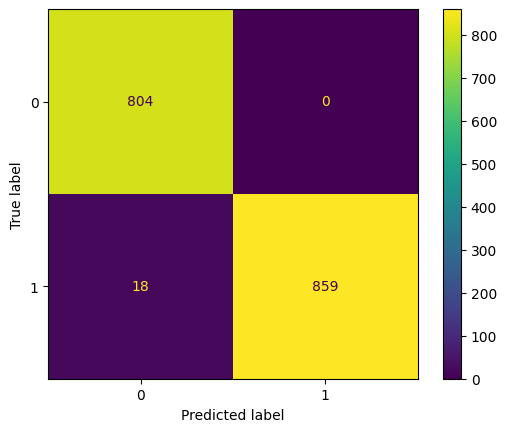

In [22]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

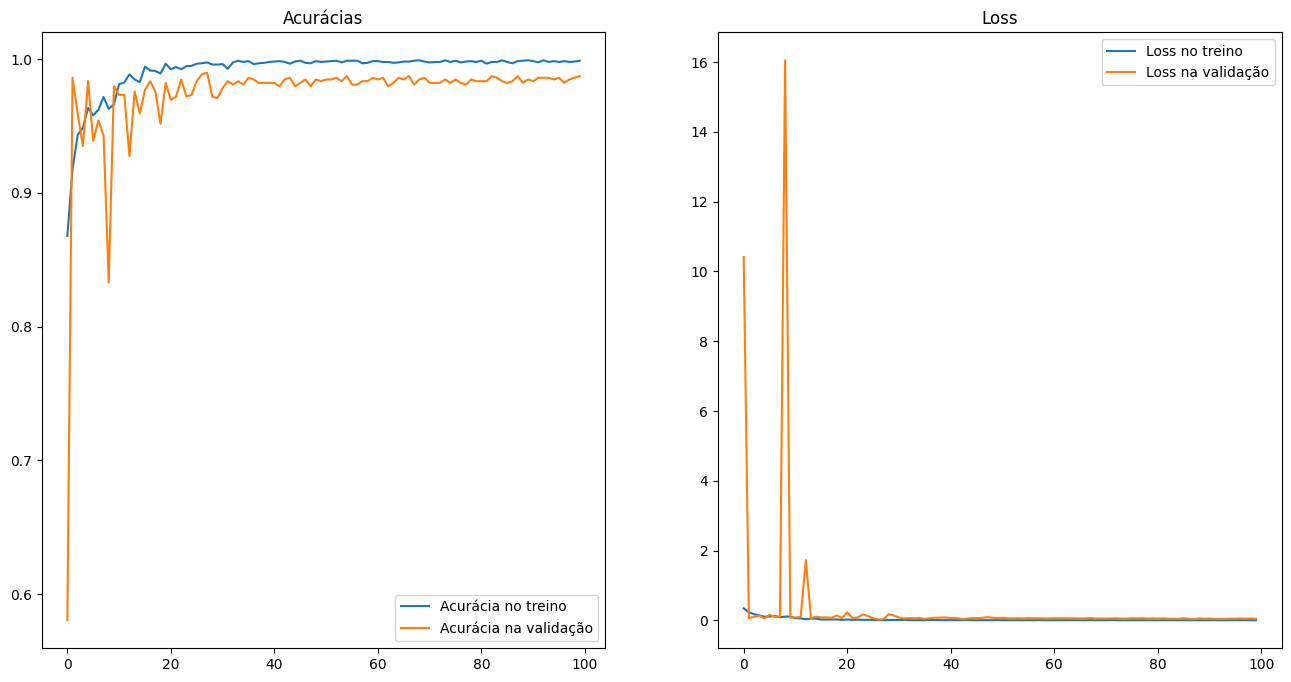

In [39]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(range(100), acc, label='Acurácia no treino')
plt.plot(range(100), val_acc, label='Acurácia na validação')
plt.legend()
plt.title("Acurácias")

plt.subplot(1, 2, 2)
plt.plot(range(100), loss, label='Loss no treino')
plt.plot(range(100), val_loss, label='Loss na validação')
plt.legend()
plt.title("Loss")

plt.show()

In [81]:
def dividir_em_janelas(image_path):
    imagem = cv2.imread(image_path)
    
    if imagem is None:
        raise ValueError("A imagem não pôde ser lida.")
    
    altura, largura, _ = imagem.shape
    tamanho_da_janela = 300
    janelas = []

    for x in range(0, largura, tamanho_da_janela):
        for y in range(0, altura, tamanho_da_janela):
            caixa = (x, y, x + tamanho_da_janela, y + tamanho_da_janela)
            janela = imagem[y:y+tamanho_da_janela, x:x+tamanho_da_janela]
            
            # Verifique se a janela tem dimensão de 300x300.
            if janela.shape == (tamanho_da_janela, tamanho_da_janela, 3):
                janelas.append(janela)

    return np.array(janelas)

In [68]:
def cortar_imagem(image_path):
    imagem = Image.open(image_path).convert("RGB")
    largura, altura = imagem.size
    janelas = []

    for x in range(0, largura, 300):
        for y in range(0, altura, 300):
            caixa = (x, y, x + 300, y + 300)
            janela = imagem.crop(caixa)
            if janela.width == 300 and janela.height == 300:
                janelas.append(np.array(janela))

    return np.array(janelas)

In [82]:
def check_noise(image_path, model):
    # image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    # if image is None:
    #     raise ValueError("A imagem não pôde ser lida.")
    windows = dividir_em_janelas(image_path)
    print("Número de janelas da imagem", windows.shape)

    for i, window in enumerate(windows):
        plt.imshow(window, cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    predict = model.predict(windows)
    # predict = threshold(predict)
    print('predição', predict)
    # noise_percent = (np.sum(predict) / len(predict)) * 100
    # print("Porcentagem de janelas com ruído", noise_percent)
    # if noise_percent > 70:
    #     return True
    # else:
    #     return False

Número de janelas da imagem (2, 300, 300, 3)


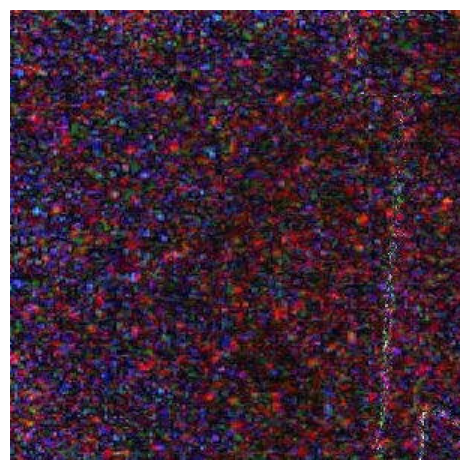

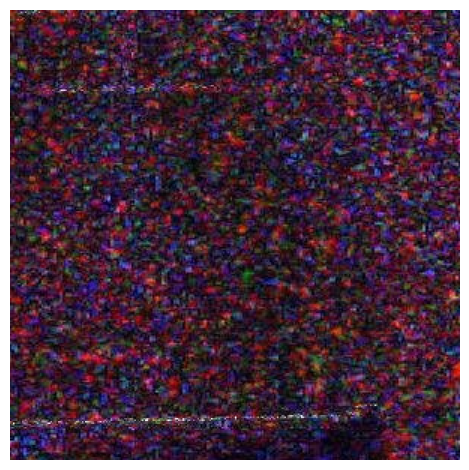

1/1 [==============================] - 2s 2s/step
predição [[0.99970907]
 [0.99962974]]
Imagem tem ruído? None


In [84]:
result = check_noise(
    'D:\\Trabalho-ReconhecimentoPadroes\\teste\\teste-low.png',
    model
)
print("Imagem tem ruído?", result)